# **Dependencies**

In [1]:
!pip install datasets
!pip install tez
!pip install transformers
!pip install pytorch-lightning
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 16.5 MB/s 
     |████████████████████████████████| 212 kB 62.1 MB/s 
     |████████████████████████████████| 163 kB 67.5 MB/s 
     |████████████████████████████████| 115 kB 65.2 MB/s 
     |████████████████████████████████| 95 kB 6.0 MB/s 
     |████████████████████████████████| 127 kB 66.4 MB/s 
     |████████████████████████████████| 115 kB 68.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████|

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Libraries**

In [126]:
from datasets import load_dataset

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np


from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import tez
from tez import TezConfig
from sklearn.metrics import f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# **Load the dataset and split it into train, valid and test**

In [4]:
_CLASS_NAMES = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

mapping = dict(zip(range(len(_CLASS_NAMES)),_CLASS_NAMES))

In [5]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train.head(10)

,text,labels,id
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,[26],edvnz26
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,[15],ee3b6wu
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"[8, 20]",ef4qmod
8,Damn youtube and outrage drama is super lucrative for reddit,[0],ed8wbdn
9,It might be linked to the trust factor of your friend.,[27],eczgv1o


# **Convert the dataset to a one-hot representation**

In [7]:
n_labels = len(mapping)

def one_hot_labels(df):
    dict_labels = []
    for i in tqdm(range(len(df)), leave=False):
        d = dict(zip(range(n_labels), [0]*n_labels))
        labels = df.loc[i]["labels"]
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
    df_labels = pd.DataFrame(dict_labels)
    return df_labels


In [8]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [9]:
train_oh_labels.shape

(43410, 28)

In [10]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

# **Data Overview**

In [11]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [12]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to cook myself.,[27],eebbqej,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",[27],ed00q6i,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
valid.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,Is this in New Orleans?? I really feel like this is New Orleans.,[27],edgurhb,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!","[4, 27]",ee84bjg,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,I've never been this sad in my life!,[25],edcu99z,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,"The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today","[4, 27]",edc32e2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.,[20],eepig6r,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
test.head()

,text,labels,id,0,1,2,3,4,5,6,...,18,19,20,21,22,23,24,25,26,27
0,"I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!",[25],eecwqtt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,It's wonderful because it's awful. At not with.,[0],ed5f85d,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Kings fan here, good luck to you guys! Will be an interesting game to watch!",[13],een27c3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"I didn't know that, thank you for teaching me something today!",[15],eelgwd1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.,[27],eem5uti,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


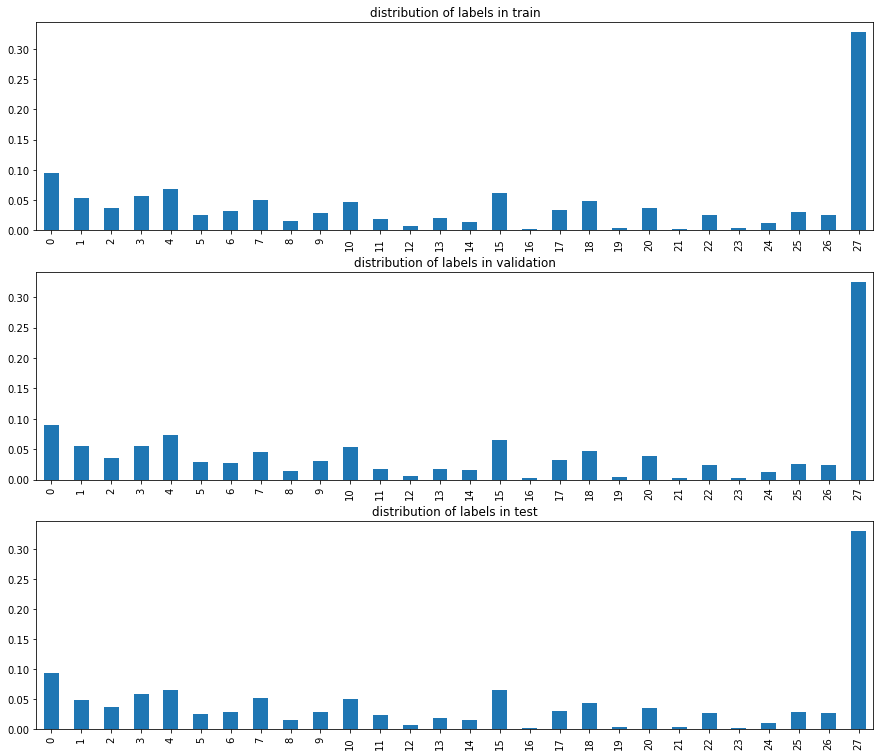

In [15]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [16]:
def show_sample_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"Sample of emotion {sentiment}: ")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

## Admiration sample

In [17]:
show_sample_data(0)

Sample of emotion admiration: 

Props to this guy, that was an amazing comment. 
---
She looks so much better. She really is pretty.
---
A girl has grown up a lot since she was a 12 year old on the show, and she's grown up to be so beautiful as well.
---
first alien is hotter tbh
---
He’s something of a genius himself.
---


## Amusement sample

In [18]:
show_sample_data(1)

Sample of emotion amusement: 

If you like that I got one that you may like. makes me laugh everytime here
---
Lol. The majority of military jobs aren’t combat related.
---
> a new release is imminent. Hahahaha
---
He's being serious but the man himself is a joke.
---
Thats about how 10% of the US population are lol
---


## Anger sample

In [19]:
show_sample_data(2)

Sample of emotion anger: 

No room. Get lost. I cc u!
---
You didn't need to split this into two posts...
---
[NAME] is huge fucking liar, but you seem to like him.
---
How is this the epitome of slavery? Nobody is forcing you to do this. Stop being dramatic.
---
Fuck the White House, fuck McDonald’s and fuck this post.
---


## Caring sample

In [20]:
show_sample_data(5)

Sample of emotion caring: 

Always go for someone you like and feel connected to.
---
As someone who's had whooping cough as an adult I will physically beat down anyone who says that especially about their kids
---
not surprised it’s too challenging for you to read
---
you'd have to help them get past [NAME] extremely tough immigration process
---
Eh for the right money you cant go wrong letting the kid earn it
---


#**Dataset Definition**

In [21]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
        
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]
        
        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

# **Emotion Classifier Model Definition**

The **Emotion Classifier Class** inherit **Tez Model** and implement its function 


In [22]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"
        self.config = TezConfig(
            fp16=True,
            val_strategy="batch",
            val_steps=100
        )
       # self = self.load("drive/MyDrive/model.bin")
    
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

    
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())
    
    
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}
 
    
    def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

# **Start the training**

In [23]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [77]:
n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="drive/MyDrive/model.bin")

model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          callbacks=[es], 
          epochs=10)

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is 

NOTE: This is old Model class and is deprecated. It will no longer be maintained! Please use version > 0.5.1. Its much better and supports multi-gpu training too!


100%|██████████| 340/340 [00:13<00:00, 25.37it/s, auc=0.947, loss=0.0921, stage=valid]


In [25]:
model.load("drive/MyDrive/model.bin", device="cuda")

In [26]:
test_dataset = GoEmotionDataset(test.text.tolist(), test[range(n_labels)].values.tolist())
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

# **Test Set Evaluation**

In [27]:
outputs = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        output, loss, acc = model.forward(batch["ids"].to("cuda"), 
                                          batch["mask"].to("cuda"), 
                                          #batch["token_type_ids"].to("cuda"),
                                          batch["targets"].to("cuda")
                                         )
        outputs.append(output)

  0%|          | 0/85 [00:00<?, ?it/s]

In [28]:
outputs = torch.cat(outputs)
outputs = torch.sigmoid(outputs)
outputs = outputs.cpu().detach().numpy()

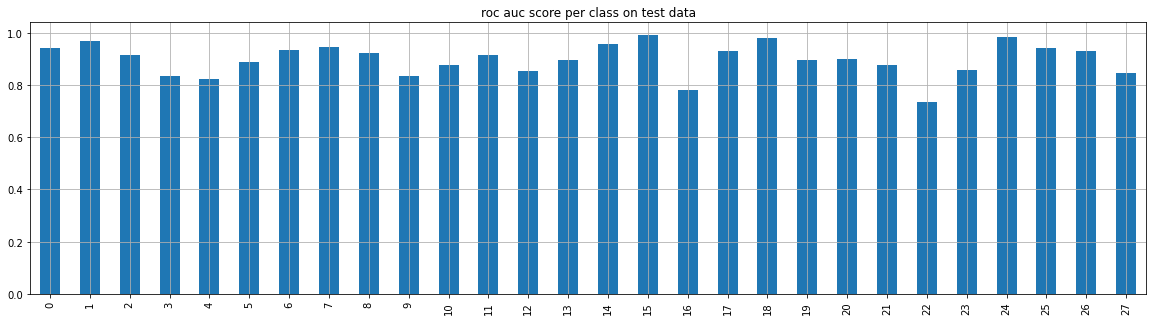

In [29]:
roc_metrics = []

for i in range(n_labels):
    roc = metrics.roc_auc_score(test[i].values, outputs[:, i])
    roc_metrics.append(roc)

s = pd.Series(roc_metrics, index=range(n_labels))

s.plot(kind="bar", figsize=(20, 5), title="roc auc score per class on test data", grid=True)

In [30]:
tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )

In [73]:
def pred_sentence_emotions(text, topn=5):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)

    probas = probas.cpu().numpy()[0][::-1]
    indices = indices.cpu().numpy()[0][::-1]

    for i, p in zip(indices[:topn], probas[:topn]):
        print(mapping[i]," --> ", p)
    return ""

# **Error Analysis**

In [44]:
def get_emotions(text, topn=28):
    max_len = 35
    with torch.no_grad():

        inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)
        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)
    probas = probas.cpu().numpy()[0][::-1]

    return probas

In [33]:
labels = _CLASS_NAMES

preds = np.zeros((len(test), len(labels)))

for i, j in enumerate(preds):
    preds[i] = get_emotions(test['text'][i])

In [45]:
result = pd.concat([test["text"], pd.DataFrame(preds, columns = labels)], axis=1)
result.to_csv('result.csv', index=False)
result.head(30)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!",0.569744,0.432736,0.236092,0.033780,0.028162,0.027695,0.024665,0.024581,0.024432,...,0.016766,0.016048,0.014417,0.013721,0.011768,0.011208,0.008616,0.006373,0.006344,0.006270
1,It's wonderful because it's awful. At not with.,0.732912,0.380134,0.122746,0.107670,0.069922,0.060826,0.050479,0.048899,0.047971,...,0.015554,0.014836,0.013886,0.013596,0.012177,0.008116,0.007406,0.006869,0.005705,0.003115
2,"Kings fan here, good luck to you guys! Will be an interesting game to watch!",0.595163,0.181437,0.175216,0.121907,0.117449,0.050104,0.043302,0.042972,0.023850,...,0.004407,0.003482,0.003457,0.003255,0.002264,0.001598,0.001533,0.001397,0.001369,0.000914
3,"I didn't know that, thank you for teaching me something today!",0.939497,0.023369,0.013906,0.013174,0.011891,0.011491,0.010975,0.010350,0.010285,...,0.002834,0.002615,0.002003,0.002001,0.001441,0.001378,0.001276,0.001127,0.000727,0.000604
4,They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.,0.539910,0.175357,0.112122,0.075337,0.049184,0.029025,0.024940,0.023818,0.017788,...,0.005092,0.004151,0.003734,0.003369,0.003036,0.002404,0.002125,0.001823,0.000969,0.000141
5,Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you.,0.976231,0.016977,0.013930,0.012921,0.011722,0.008030,0.007745,0.007385,0.007143,...,0.002712,0.002315,0.001909,0.001849,0.001839,0.001681,0.001514,0.000923,0.000772,0.000752
6,You’re welcome,0.942917,0.057356,0.035684,0.029216,0.020108,0.014495,0.011501,0.008877,0.006358,...,0.003456,0.002684,0.002472,0.002061,0.001837,0.001807,0.001686,0.001636,0.001471,0.001061
7,100%! Congrats on your job too!,0.737235,0.711279,0.088729,0.033438,0.017103,0.015178,0.011617,0.010779,0.010258,...,0.006797,0.006613,0.004995,0.004432,0.004123,0.003501,0.002843,0.002664,0.002479,0.001617
8,I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are,0.741968,0.303943,0.059619,0.046696,0.037564,0.037561,0.036284,0.035578,0.027691,...,0.012273,0.011504,0.011031,0.009250,0.009118,0.008138,0.007559,0.007198,0.006284,0.004596
9,"Girlfriend weak as well, that jump was pathetic.",0.418958,0.403282,0.085703,0.067004,0.054869,0.045894,0.031963,0.028086,0.026207,...,0.006681,0.006373,0.005735,0.005377,0.004298,0.003971,0.003900,0.002978,0.002130,0.001126


## False emotion

### Showing predictions for first 50 test dataset sentence

In [75]:
for ind in result.head(50).index:
    print("Sentence: ", result["text"][ind])
    print("Prediction: ")
    print(pred_sentence_emotions(result["text"][ind]))

Sentence:  I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
Prediction: 
remorse  -->  0.6026722
love  -->  0.46156013
sadness  -->  0.27652732
desire  -->  0.041518535
neutral  -->  0.03912903

Sentence:  It's wonderful because it's awful. At not with.
Prediction: 
admiration  -->  0.5658779
disgust  -->  0.2679214
annoyance  -->  0.07172442
disapproval  -->  0.062975354
fear  -->  0.054554492

Sentence:  Kings fan here, good luck to you guys! Will be an interesting game to watch! 
Prediction: 
optimism  -->  0.6295903
admiration  -->  0.1879585
joy  -->  0.17816743
gratitude  -->  0.15666041
caring  -->  0.13196726

Sentence:  I didn't know that, thank you for teaching me something today!
Prediction: 
gratitude  -->  0.96866834
disapproval  -->  0.019724013
approval  -->  0.016036354
confusion  -->  0.01400227
neutral  -->  0.01386093

Sentence:  They got bored from haunting earth for thousands of years and ultimately moved on to the

In [76]:
for ind in result.head(100)[50:].index:
    print("Sentence: ", result["text"][ind])
    print("Prediction: ")
    print(pred_sentence_emotions(result["text"][ind]))

Sentence:  They started seeling alcohol a while ago, when she called her mafia friend to get help for the speakeasy.
Prediction: 
neutral  -->  0.9079432
approval  -->  0.026301486
annoyance  -->  0.022306826
realization  -->  0.017262554
disappointment  -->  0.008595102

Sentence:  Get back on your meds mate..You aren't funny at all...
Prediction: 
neutral  -->  0.32212225
annoyance  -->  0.27785277
caring  -->  0.14629993
anger  -->  0.14617738
disapproval  -->  0.120133705

Sentence:  "But Aunt [NAME], I don't *want* to send Grandma back to Italy!"
Prediction: 
neutral  -->  0.7609953
disapproval  -->  0.27245325
annoyance  -->  0.057156853
disappointment  -->  0.03336166
anger  -->  0.015529892

Sentence:  Even the royals aren't immune to it.
Prediction: 
neutral  -->  0.73411083
disapproval  -->  0.1443971
annoyance  -->  0.043327786
approval  -->  0.042521738
disappointment  -->  0.00938248

Sentence:  I thought it said “now my biggest fear is the thing living inside my casket” l

## Summary

Some of the predictions emotions are not appropriate with the sentence, from our analysis, this is because of the dataset is having a bad distribution, with 30% of the data is categorized as "Neutral". While the other emotion is only less than 30%. Consequently this will affect the result of the predictions that the sentence will be misslabeled with the default label "Neutral"

For example the sentence 

<br/>

---
But Aunt [NAME], I don't *want* to send Grandma back to Italy!


---


<br/>

Give the following prediction

<br/>

---
neutral  -->  0.7609953 <br/>
disapproval  -->  0.27245325 <br/>
annoyance  -->  0.057156853 <br/>
disappointment  -->  0.03336166 <br/>
anger  -->  0.015529892 <br/>

---

<br/>
If we traverse through the classes, the proper emotion for this sentence should be disaggrement and disapproval, however the score is preety low in the result of this prediction compare to the "Neutral" emotion.



# **Analysis**

## Converting to numpy format

### Convert Probabilistic Predictions to hard classes


In [123]:
df_pred = pd.DataFrame(preds, columns = labels)
y_prob = np.array(preds)

thresh = 0.3

y_pred = np.array([[1 if i > thresh else 0 for i in j] for j in y_prob])
y_pred

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

### Convert Test Data Frame to Numpy Array


In [118]:
y_true = np.array(test_oh_labels)
y_true

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

## F1 Score

In [124]:
def f1_sampled(actual, pred):
    #converting the multi-label classification to a binary output
    mlb = MultiLabelBinarizer()
    actual = mlb.fit_transform(actual)
    pred = mlb.fit_transform(pred)

    #fitting the data for calculating the f1 score 
    f1 = f1_score(actual, pred, average = "samples")
    return f1

print(f1_sampled(y_true, y_pred))

0.9834776733615872


## Hamming Loss

In [127]:
hamming_loss(y_true, y_pred)

0.07629840216904893

# **Test some sentences**

In [131]:
print(pred_sentence_emotions("It's wonderful because it's awful. At not with."))

disgust  -->  0.72195834
admiration  -->  0.39190334
annoyance  -->  0.106706776
disappointment  -->  0.093996294
disapproval  -->  0.07391313



In [132]:
print(pred_sentence_emotions("i miss my brother"))

sadness  -->  0.9284466
disappointment  -->  0.17097245
neutral  -->  0.055070378
remorse  -->  0.041871678
caring  -->  0.0170289



In [133]:
print(pred_sentence_emotions("funny how this craps out!"))

amusement  -->  0.94056934
joy  -->  0.14075944
admiration  -->  0.020517504
annoyance  -->  0.013773694
excitement  -->  0.010863595



In [134]:
print(pred_sentence_emotions("i hope you go to hell! "))

optimism  -->  0.86965346
caring  -->  0.048605334
desire  -->  0.04186225
anger  -->  0.023514697
neutral  -->  0.020636741



In [135]:
print(pred_sentence_emotions("you might have a point, but i strongly disagree with you"))

disapproval  -->  0.8945599
annoyance  -->  0.06589069
approval  -->  0.049318988
disappointment  -->  0.04658352
confusion  -->  0.030794917



In [136]:
print(pred_sentence_emotions("i'm feeling very confident with this solution"))

optimism  -->  0.6260518
approval  -->  0.48255414
admiration  -->  0.063750856
excitement  -->  0.058070693
realization  -->  0.05419025



In [137]:
print(pred_sentence_emotions("try to be more careful my friend"))

caring  -->  0.8074218
neutral  -->  0.06994176
sadness  -->  0.048619635
approval  -->  0.043507647
optimism  -->  0.029988442

